In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline


In [7]:
ratings = pd.read_csv('/Users/deborahgemellaro/Downloads/ml-20m/ratings.csv')
movies = pd.read_csv('/Users/deborahgemellaro/Downloads/ml-20m/movies.csv')
tags = pd.read_csv('/Users/deborahgemellaro/Downloads/ml-20m/tags.csv')
links = pd.read_csv('/Users/deborahgemellaro/Downloads/ml-20m/links.csv')

In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [10]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [12]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [13]:
print(ratings.shape, movies.shape, tags.shape, links.shape)

(20000263, 4) (27278, 3) (465564, 4) (27278, 3)


In [46]:
df = pd.merge(ratings, movies, on='movieId')

In [62]:
df_slice = df.iloc[:18750000]
df_slice.shape

(18750000, 6)

In [21]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head(20)

title
Stealing a Nation (2004)                                 5.0
Human Behavior Experiments, The (2006)                   5.0
Boys Diving, Honolulu (1901)                             5.0
Rigoletto (1993)                                         5.0
Paying the Price: Killing the Children of Iraq (2000)    5.0
Peace, Propaganda & the Promised Land (2004)             5.0
Boys (Drenge) (1977)                                     5.0
Taxi Blues (1990)                                        5.0
Blue Swallow (Cheong yeon) (2005)                        5.0
Victor and the Secret of Crocodile Mansion (2012)        5.0
1971 (2014)                                              5.0
Best of Ernie and Bert, The (1988)                       5.0
Story of Science, The (2010)                             5.0
Central Park (1991)                                      5.0
Flight of the Conchords: A Texan Odyssey (2006)          5.0
Serving Life (2011)                                      5.0
Going Down in LA-L

In [22]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head(20)

title
Pulp Fiction (1994)                                      67310
Forrest Gump (1994)                                      66172
Shawshank Redemption, The (1994)                         63366
Silence of the Lambs, The (1991)                         63299
Jurassic Park (1993)                                     59715
Star Wars: Episode IV - A New Hope (1977)                54502
Braveheart (1995)                                        53769
Terminator 2: Judgment Day (1991)                        52244
Matrix, The (1999)                                       51334
Schindler's List (1993)                                  50054
Toy Story (1995)                                         49695
Fugitive, The (1993)                                     49581
Apollo 13 (1995)                                         47777
Independence Day (a.k.a. ID4) (1996)                     47048
Usual Suspects, The (1995)                               47006
Star Wars: Episode VI - Return of the Jedi (1983)

In [51]:
rating_and_count = pd.DataFrame(df_slice.groupby('title')['rating'].mean())
rating_and_count['total_ratings'] = pd.DataFrame(df_slice.groupby('title')['rating'].count())
rating_and_count.head()

,rating,total_ratings
title,,
*batteries not included (1987),3.245087,1730
10 Things I Hate About You (1999),3.473909,11613
"10,000 BC (2008)",2.513688,1863
100 Girls (2000),3.046961,362
101 Dalmatians (1996),3.078429,8581


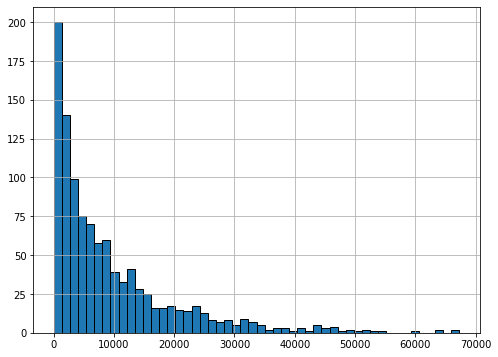

In [52]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
rating_and_count['total_ratings'].hist(bins=50)

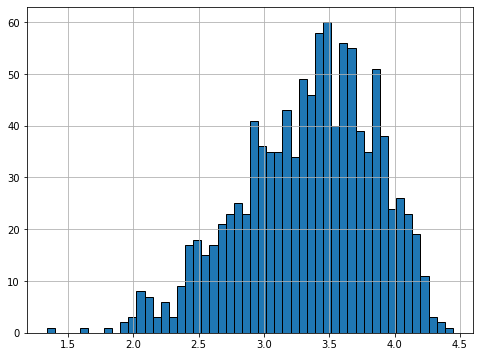

In [53]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
rating_and_count['rating'].hist(bins=50)

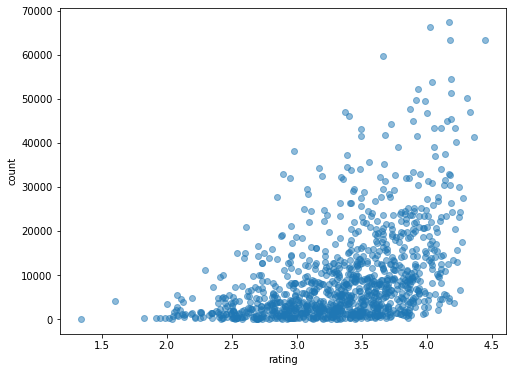

In [54]:
plt.figure(figsize=(8,6))

plt.scatter(rating_and_count.rating, rating_and_count.total_ratings, alpha=0.5)
plt.xlabel('rating')
plt.ylabel('count')
plt.show()

Now we have to create the user-item matrix which is a giant table of every movie in the database and the ratings of each by ever user. Naturally since each user will not rate anything close to every movie, we will have a very sparse matrix.

In [63]:
user_movie_rating = df_slice.pivot_table(index='userId', columns='title', values='rating')
user_movie_rating.head()

title,"""Great Performances"" Cats (1998)",'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),10 Things I Hate About You (1999),"10,000 BC (2008)",100 Girls (2000),...,Zodiac (2007),Zombieland (2009),Zookeeper (2011),Zoolander (2001),"Zorro, the Gay Blade (1981)",Zulu (1964),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
user_movie_rating.shape

(138493, 5634)

In [65]:
forrest_gump_ratings = user_movie_rating['Forrest Gump (1994)']

In [66]:
forrest_gump_ratings.head()

userId
1    NaN
2    NaN
3    NaN
4    4.0
5    NaN
Name: Forrest Gump (1994), dtype: float64

In [ ]:
movies_like_forrest_gump = user_movie_rating.corrwith(forrest_gump_ratings)


In [ ]:
corr_forrest_gump = pd.DataFrame(movies_like_forrest_gump, columns=['Correlation'])
corr_forrest_gump.dropna(inplace=True)
corr_forrest_gump.head()